This is the Inference Notebook used to test Stable-Foley on 5 random videos taken from the Greatest Hits Dataset test set. 
Follow the instructions provided as comments throughout the notebook. You will need to change the paths where specified and indicate the device that will be used by the model. 

In [1]:
import os

import hydra
import torch
import torchaudio
from stable_audio_tools.inference.generation import generate_diffusion_cond

In [ ]:
# Now you will need to login to the Hugging Face Hub to be able to upload Stale Audio Open weights.
# You have to create and authentication token and copy-paste it in the prompt.
# Follow the instruction here: https://huggingface.co/docs/huggingface_hub/guides/cli
# You will need permission to `stable-audio-open-1.0` repository (https://huggingface.co/stabilityai/stable-audio-open-1.0)
# (probably you will need to install ipywidgets first:  pip install ipywidgets)
from huggingface_hub import login
login()

In [ ]:
# params

# We will need Stable-Foley, CAVP cand CLAP checkpoints to generate audio.
# CAVP and CLAP checkpoints are available in the repository.
# CAVP ckpt: 'Stable-Video2Audio/logs/cavp_ckpt/cavp_epoch66.ckpt'
# CLAP ckpt: '/homes/rfg543/Documents/Stable-Video2Audio/logs/clap_ckpt/630k-audioset-best.pt'
# Stable-Foley ckpt: 'Stable-Video2Audio/logs/ckpts/gh-controlnet_2024-08-22-11-43-14/epoch=213-valid_loss=0.493.ckpt' (there are other checkpoints available in the repository in the same folder)


seed = 42
num_samples = 2 # number of samples to generate (in this case 2 outputs will be generated)
exp_cfg = "train_gh_controlnet"
ckpt_path = "/homes/rfg543/Documents/Stable-Video2Audio/logs/ckpts/gh-controlnet_2024-08-22-11-43-14/epoch=213-valid_loss=0.493.ckpt" # !!! <--- change this path to your absolute path to '/Stable-Video2Audio/logs/ckpts/gh-controlnet_2024-08-22-11-43-14/last.ckpt'
dataset_path = "/homes/rfg543/Documents/Stable-Video2Audio/notebook/gh_data/samples-processed-4fps-44kHz" # !!! <--- change this path to your absolute path to '/Stable-Video2Audio/notebook/gh_data/samples-processed-4fps-44kHz'

torch.cuda.set_device(7) # !!! <--- change this to your GPU device ID (es. 0, 1, 2, ...)

import sys
sys.path.append("..")

# load config: This is the config file that was used to train the model, it is needed to load the model and the dataloader
with hydra.initialize(config_path="..", version_base=None):
    cond_cfg = hydra.compose(config_name="config", overrides=[f'exp={exp_cfg}',
                                                              f"datamodule.root_dir=/homes/rfg543/Documents/Stable-Video2Audio/notebook/gh_data/samples-processed-4fps-44kHz", # !!! <--- change this path to your absolute path to '/Stable-Video2Audio/notebook/gh_data/samples-processed-4fps-44kHz'
                                                              f"datamodule.test_split_file_path={dataset_path}/test.txt",
                                                              f"datamodule.test_data_to_use=1.0",]) # you can choose the percentage of the dataset to use for testing
    
# init model
model = hydra.utils.instantiate(cond_cfg["model"])
ckpt = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(ckpt['state_dict'], strict=False)
model = model.cuda()
# load dataloader
datamodule = hydra.utils.instantiate(cond_cfg["datamodule"])
datamodule.setup(stage="test")
test_dataloader = datamodule.test_dataloader()

In [4]:
# load conditioning: This is the conditioning that will be used to generate the audio
# The model will generate the audio conditioned on the envelope as the ControlNet input
# and audio CLAP embeddings and frames CAVP embedding as cross-attention conditionings
# seconds_start and seconds_total (default=10s, the output will be 10 seconds long) 
# are used to generate the audio for a specific time range
from main.module_controlnet import window_rms, low_pass_filter

# window sizes for RMS and low-pass filter, these values ensure tgat RMS has the same shape as the audio
# (this is required for the ControlNet to work properly)
# low-pass filter is used to smooth the envelope
rms_window_size = 10000
low_pass_window_size = 2000

x, frames, seconds_start, seconds_total, item = next(iter(test_dataloader))
rms_envelope = window_rms(x, window_size=rms_window_size)
filtered_envelope = low_pass_filter(rms_envelope, window_size=low_pass_window_size)
num_samples = min(num_samples, x.shape[0])
device = next(model.parameters()).device

# manipulate envelope if you want, i.e. 1) zero out some parts, 2) reduce amplitude of some parts

# filtered_envelope[:, :, 220500:] = 0 # zero out
# filtered_envelope[:, :, 220500:] *= 0.5 # reduce amplitude

conditioning = [{
    "envelope": filtered_envelope[i:i+1].to(device), # ControlNet input
    "audio": x[i:i+1], # audio CLAP embeddings (cross-attention)
    "frames": frames[i:i+1], # frames CAVP embeddings (cross-attention)
    "seconds_start": seconds_start[i], # start time
    "seconds_total": seconds_total[i], # total time
} for i in range(num_samples)]

In [ ]:
# Plot the RMS envelope
# We can see the RMS envelope that will be used to condition the audio generation
# (this is the RMS envelope of the first test sample, you can change the index to see the RMS envelope of other samples)
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(filtered_envelope[0, 0].cpu())
plt.show()

In [ ]:
# generate: This will generate the audio conditioned on the conditioning provided
# You can change the parameters of the diffusion model in the generate_diffusion_cond function
# For example, you can change the number of steps for the diffusion process, etc. 

output = generate_diffusion_cond(
            model.model,
            seed=seed,
            batch_size=num_samples,
            steps=100,
            cfg_scale=7.0,
            conditioning=conditioning,
            sample_size=x.shape[-1],
            sigma_min=0.3,
            sigma_max=500,
            sampler_type="dpmpp-3m-sde",
            device="cuda"
        )

In [6]:
# save results
# The generated audio will be saved in the "out" folder that will be created in 
# 'Stable-Video2Audio/notebook/out'
# For every sample, two files will be saved: one for the input (target audio) and one for the output (generated audio)
# The files will be named as "input_{i}_video_{video_name}.wav" and "output_{i}_video_{video_name}.wav"
# This will be useful to compare the generated audio with the target audio
if "out" not in os.listdir():
    os.mkdir("out")

for i in range(num_samples):
    video_name = item[i]["video_name"]
    # this is for num_samples = 2
    torchaudio.save(f"out/input_{i}_video_{video_name}.wav", x[i].cpu(), sample_rate=44100)
    torchaudio.save(f"out/output_{i}_video_{video_name}.wav", output[i].cpu(), sample_rate=44100)

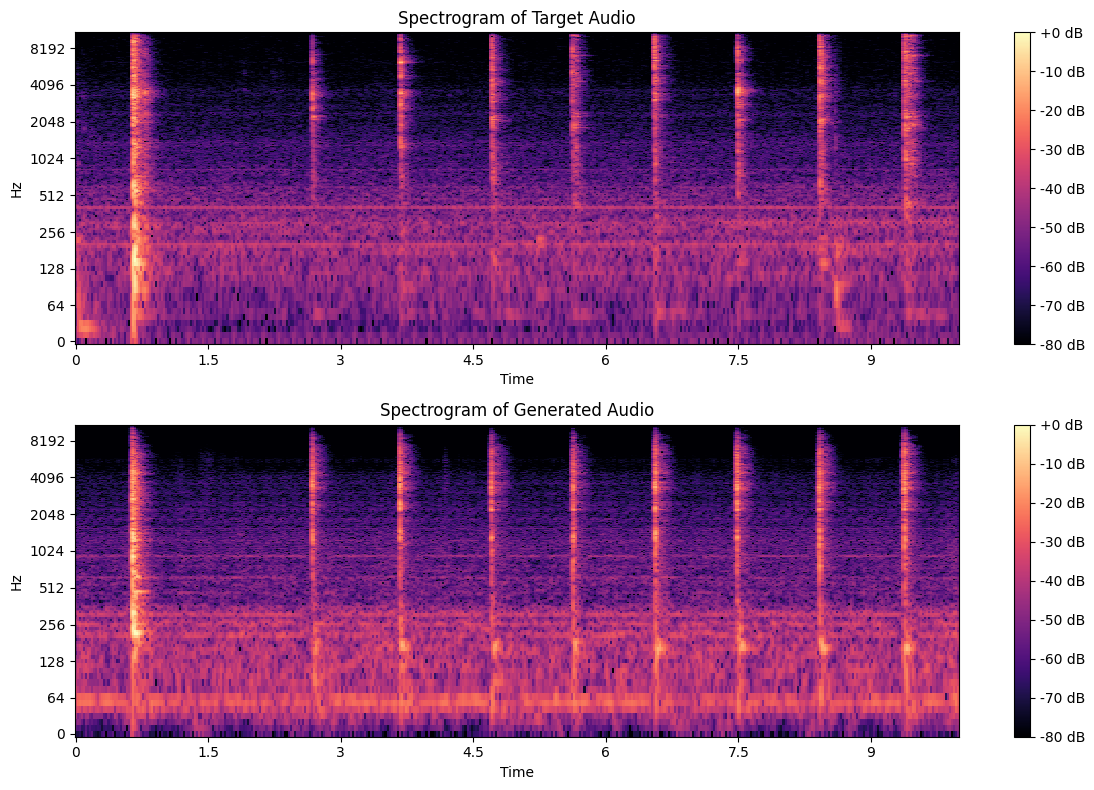

In [7]:
# This will plot the spectrogram of the target audio and the generated audio so we can compare them

import librosa
import librosa.display
import numpy as np

audio_path1 = "/homes/rfg543/Documents/Stable-Video2Audio/notebook/out/input_0_video_2015-02-16-16-49-06.wav" # !!! <--- change this path to your absolute path to the target audio, i.e.'/Stable-Video2Audio/notebook/out/input_0_video_2015-02-16-16-49-06.wav'
audio_path2 = "/homes/rfg543/Documents/Stable-Video2Audio/notebook/out/output_0_video_2015-02-16-16-49-06.wav" # !!! <--- change this path to your absolute path to the generated audio, i.e.'/Stable-Video2Audio/notebook/out/output_0_video_2015-02-16-16-49-06.wav'

y1, sr1 = librosa.load(audio_path1)
y2, sr2 = librosa.load(audio_path2)

D1 = librosa.amplitude_to_db(np.abs(librosa.stft(y1)), ref=np.max)
D2 = librosa.amplitude_to_db(np.abs(librosa.stft(y2)), ref=np.max)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.specshow(D1, sr=sr1, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Target Audio')

plt.subplot(2, 1, 2)
librosa.display.specshow(D2, sr=sr2, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Generated Audio')

plt.tight_layout()
plt.show()

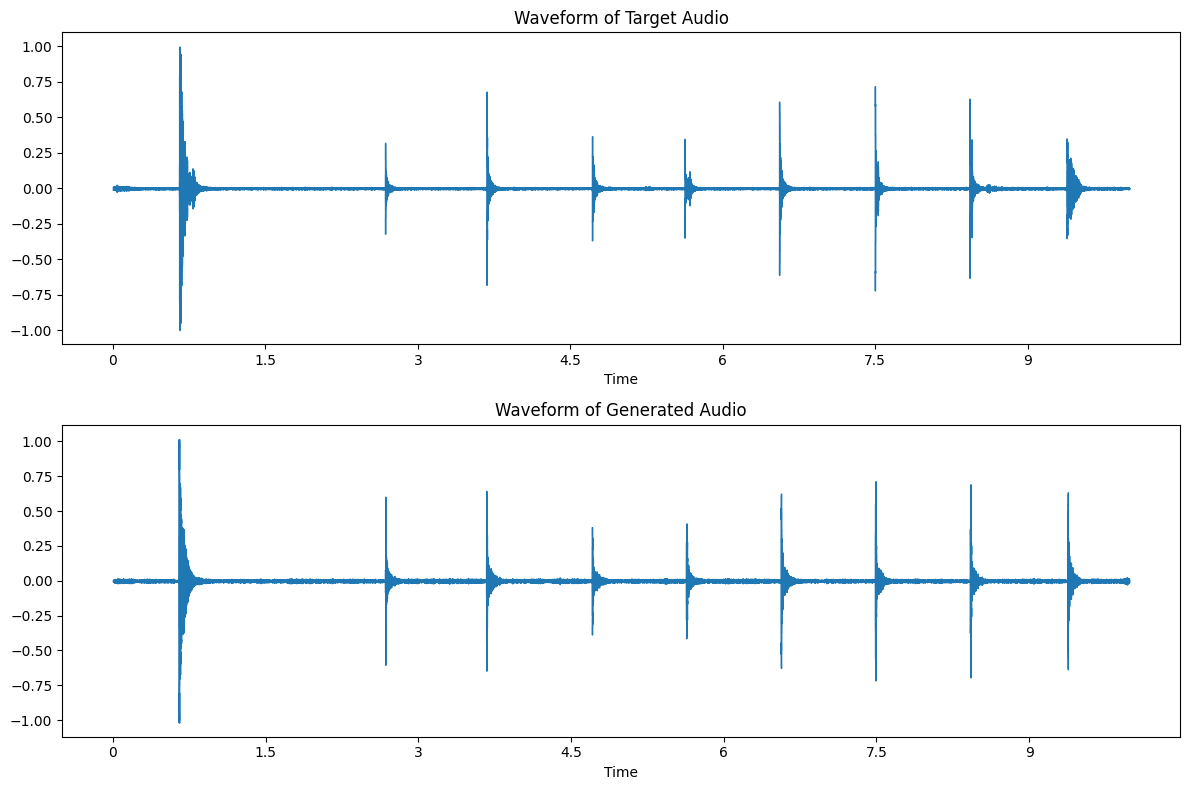

In [8]:
# This will plot the waveform of the target audio and the generated audio

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y1, sr=sr1)
plt.title('Waveform of Target Audio')

plt.subplot(2, 1, 2)
librosa.display.waveshow(y2, sr=sr2)
plt.title('Waveform of Generated Audio')

plt.tight_layout()
plt.show()

# Enjoy!

In [ ]:
# load the two audio files and listen to them to compare the target audio with the generated audio
import soundfile as sf
import IPython.display as ipd
# target audio
ipd.Audio(audio_path1)




In [ ]:
# generated audio
ipd.Audio(audio_path2)